In [12]:
import numpy as np
import pandas as pd
import cvxpy as cp

In [13]:
def opt_fractions(alpha,r):
    """ Computes optimal fractions for the power utility. 
        The case alpha=0 corresponds to the logarithmic utility.
    """
    x = cp.Variable(d)
    constraints=[x>=0,cp.sum(x)==1]
    if alpha==0:
        obj=cp.sum(cp.log(r@x))
    else:
        obj=cp.sum(cp.power(r@x,alpha))
    problem=cp.Problem(cp.Maximize(obj),constraints)
    problem.solve()
    return x.value

In [14]:
def opt_fractions_quadr(alpha,mu,Sigma):
    """ Computes optimal fractions for the quadratic approximation of the power utility. 
        The case alpha=0 corresponds to the logarithmic utility.
    """
    x = cp.Variable(d)
    constraints=[x>=0,cp.sum(x)==1]
    obj=mu@x-(1-alpha)*cp.quad_form(x,Sigma)/2
    problem=cp.Problem(cp.Maximize(obj),constraints)
    problem.solve()
    return x.value

In [15]:
def refine(w,tol=1/10**3):
    """ Drops small weights and normalizes the remaining ones """
    d=w.shape[0]
    opt_num=[i for i in range(d) if w[i]>tol]
    w=w[opt_num]/np.sum(w[opt_num])    
    return opt_num, w

Optimal portfolios for logartimic utility and its quadratic approximation (Table 2)

In [16]:
datasets=['NYSE_1.csv','NYSE_2.csv','SP500.csv','DJIA.csv']
for data in datasets:
    stocks=pd.read_csv(data)
    N=stocks.shape[0]
    d=stocks.shape[1]
    r=np.zeros((N,d))
    r=stocks.to_numpy()
    frac=np.zeros(d)
    frac_quadr=np.zeros(d)
    mu=np.mean(r-1,axis=0)
    Sigma=(r.T-1)@(r-1)/N    
    frac=opt_fractions(0,r)
    frac_quadr=opt_fractions_quadr(0,mu,Sigma)
    print(data.replace('.csv',''))
    print('BCRP portfolio:\n',refine(frac))
    print('Quadratic approximation:\n',refine(frac_quadr))
    print('Cumulative wealth:',np.prod(r@frac))

NYSE_1
BCRP portfolio:
 ([5, 8, 19, 22, 25], array([0.27673488, 0.19530288, 0.09271132, 0.25070615, 0.18454476]))
Quadratic approximation:
 ([5, 8, 19, 22, 25], array([0.2773918 , 0.19440774, 0.09487076, 0.24804043, 0.18528927]))
Cumulative wealth: 250.59706725355232
NYSE_2
BCRP portfolio:
 ([9, 16, 18], array([0.1774052 , 0.74702162, 0.07557318]))
Quadratic approximation:
 ([9, 16, 18], array([0.17653955, 0.74721037, 0.07625008]))
Cumulative wealth: 4100.83040148536
SP500
BCRP portfolio:
 ([2, 17, 18], array([0.08321975, 0.69686737, 0.21991287]))
Quadratic approximation:
 ([2, 17, 18], array([0.08611081, 0.69309728, 0.22079191]))
Cumulative wealth: 4.068630936832602
DJIA
BCRP portfolio:
 ([2, 3, 7], array([0.15835138, 0.52702498, 0.31462365]))
Quadratic approximation:
 ([2, 3, 7], array([0.16174616, 0.5231849 , 0.31506894]))
Cumulative wealth: 1.2399285324495561


Excess risk and excess return of the optimal portolios for relative vs ordinary power utility, 
$\alpha\in \{0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9\}.$ (Table 3)

The risk-return curves for the same values of alpha. (Fig.2)

NYSE_1
alpha: 0.1
excess risk: -2.343965841018786 excess return: -1.1144373825594585
ordinary utility risk and return: 39.416374565750544 117.29694226113203
relative utility risk and return: 37.07240872473176 116.18250487857257
alpha: 0.2
excess risk: -5.511444973499259 excess return: -2.507201384283519
ordinary utility risk and return: 42.4515382950531 118.56401647135426
relative utility risk and return: 36.94009332155384 116.05681508707075
alpha: 0.3
excess risk: -9.963696244239841 excess return: -4.293707573061624
ordinary utility risk and return: 46.87184673449022 120.19149218791068
relative utility risk and return: 36.90815049025038 115.89778461484906
alpha: 0.4
excess risk: -16.587241988069394 excess return: -6.677688155050433
ordinary utility risk and return: 53.690250462730134 122.36496522240697
relative utility risk and return: 37.10300847466074 115.68727706735653
alpha: 0.5
excess risk: -27.225148465408914 excess return: -10.030011905594122
ordinary utility risk and return: 6

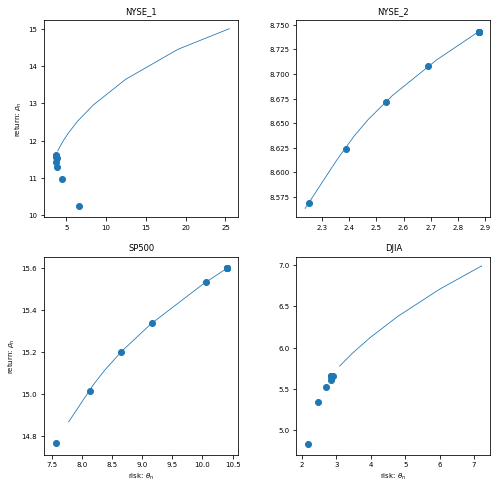

In [20]:
import matplotlib.pyplot as plt
alphas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(wspace=0.3)
ret=np.zeros(len(alphas))
risk=np.zeros(len(alphas))
ret_rel=np.zeros(len(alphas))
risk_rel=np.zeros(len(alphas))
p=-1
for data,ax in zip(['NYSE_1.csv','NYSE_2.csv','SP500.csv','DJIA.csv'],axes.ravel()):
    p+=1
    stocks=pd.read_csv(data)
    N=stocks.shape[0]
    d=stocks.shape[1]
    r=np.zeros((N,d))
    r=stocks.to_numpy()
    frac=np.zeros(d)
    frac_rel=np.zeros(d)
    mu=np.mean(r-1,axis=0)
    r_rel=r/np.max(r,axis=1).reshape(-1,1)
    s=-1
    for alpha in alphas:
        s+=1
        frac=opt_fractions(alpha,r)
        frac_rel=opt_fractions(alpha,r_rel)
        risk[s]=np.std((r-1)@frac)**2
        ret[s]=mu@frac
        risk_rel[s]=np.std((r-1)@frac_rel)**2
        ret_rel[s]=mu@frac_rel 
        if s==0: print(data.replace('.csv',''))       
        print('alpha:',alpha)
        print('excess risk:',10**5*risk_rel[s]-10**5*risk[s],'excess return:',10**5*ret_rel[s]-10**5*ret[s]) 
        print('ordinary utility risk and return:',10**5*risk[s],10**5*ret[s])
        print('relative utility risk and return:',10**5*risk_rel[s],10**5*ret_rel[s])
      #  print(refine(frac_rel))
      #  print(refine(frac))
    ax.plot(10**4*risk,10**4*ret,linewidth=0.8)
    ax.scatter(10**4*risk_rel,10**4*ret_rel)
    ax.set_title(data.replace('.csv',''))
    if p==2 or p==3: ax.set_xlabel('risk: '+r'$\theta_n$')
    if p==0 or p==2: ax.set_ylabel('return: '+r'$\rho_n$')
fig.savefig('risk-return_basic.eps', dpi=400, bbox_inches='tight')

The same as the previous cell for quadratic approximation. The concrete results are not included in the paper.

Quadratic approximation
NYSE_1
alpha: 0.1
excess risk: -2.267710629133461 -1.1611051485919148
ordinary utility risk and return: 117.13806261894423
relative utility risk and return: 36.79306385215935 115.97695747035232
alpha: 0.2
excess risk: -5.243589326755604 -2.5417859647712504
ordinary utility risk and return: 118.39177953217798
relative utility risk and return: 36.774397211094545 115.84999356740673
alpha: 0.3
excess risk: -9.429363870145629 -4.316947014145342
ordinary utility risk and return: 120.00370127776422
relative utility risk and return: 36.90242745192912 115.68675426361888
alpha: 0.4
excess risk: -15.63977497594535 -6.683828413310181
ordinary utility risk and return: 122.15293027187917
relative utility risk and return: 37.33918730356786 115.46910185856899
alpha: 0.5
excess risk: -26.389875546413094 -10.18904713720228
ordinary utility risk and return: 125.16185086364011
relative utility risk and return: 37.614354064180844 114.97280372643783
alpha: 0.6
excess risk: -45.304684

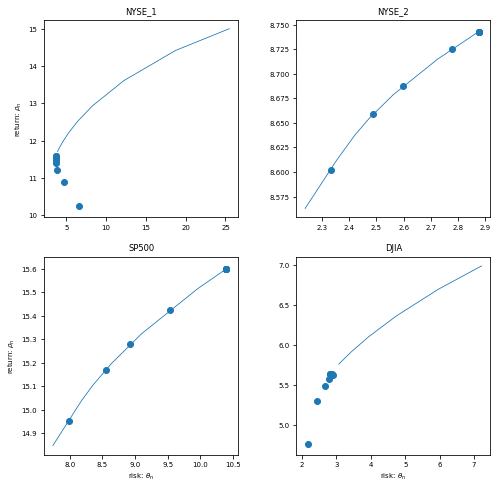

In [22]:
alphas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(wspace=0.3)
ret=np.zeros(len(alphas))
risk=np.zeros(len(alphas))
ret_rel=np.zeros(len(alphas))
risk_rel=np.zeros(len(alphas))
p=-1
print('Quadratic approximation')
for data,ax in zip(['NYSE_1.csv','NYSE_2.csv','SP500.csv','DJIA.csv'],axes.ravel()):
    p+=1
    stocks=pd.read_csv(data)
    N=stocks.shape[0]
    d=stocks.shape[1]
    r=np.zeros((N,d))
    r=stocks.to_numpy()
    r_rel=r/np.max(r,axis=1).reshape(-1,1)
    mu=np.mean(r-1,axis=0)
    Sigma=(r.T-1)@(r-1)/N 
    mu_rel=np.mean(r_rel-1,axis=0)
    Sigma_rel=(r_rel.T-1)@(r_rel-1)/N 
    frac=np.zeros(d)
    frac_rel=np.zeros(d)
    s=-1
    for alpha in alphas:
        s+=1
        frac=opt_fractions_quadr(alpha,mu,Sigma)
        frac_rel=opt_fractions_quadr(alpha,mu_rel,Sigma_rel)
        risk[s]=np.std((r-1)@frac)**2
        ret[s]=mu@frac
        risk_rel[s]=np.std((r-1)@frac_rel)**2
        ret_rel[s]=mu@frac_rel 
        if s==0: print(data.replace('.csv',''))        
        print('alpha:',alpha)           
        print('excess risk:',10**5*risk_rel[s]-10**5*risk[s],10**5*ret_rel[s]-10**5*ret[s]) 
        print('ordinary utility risk and return:',10**5*ret[s])
        print('relative utility risk and return:',10**5*risk_rel[s],10**5*ret_rel[s])
       # print(refine(frac_rel))
      #  print(refine(frac))
    ax.plot(10**4*risk,10**4*ret,linewidth=0.8)
    ax.scatter(10**4*risk_rel,10**4*ret_rel)
    ax.set_title(data.replace('.csv',''))
    if p==2 or p==3: ax.set_xlabel('risk: '+r'$\theta_n$')
    if p==0 or p==2: ax.set_ylabel('return: '+r'$\rho_n$')

The cell first computes the statistical estimates $\mu$, $\Sigma$, then generates $m=10^6$ returns 
$$ r_k^i=\exp(\zeta_k^i),\quad \zeta_k\sim N(\tilde\mu,\Sigma),\quad   \tilde\mu^i=\mu^i-\frac{1}{2}\sum_{p=1}^m(\Sigma^{ip})^2 $$
from the geometric Brownian motion model. After this the quadratic approximation problems for ordinary and relative power utilities are solved. 

Output:

Excess risk and excess return of the optimal portolios for relative vs ordinary power utility, 
$\alpha\in \{0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9\}.$ The risk-return curves for the same values of alpha.

Concrete results are not included in the paper.

NYSE_1
alpha: 0.1
excess risk: -2.0451496234385615 -0.9900446978074768
ordinary utility risk and return: 39.11512941356077 117.24688573559918
relative utility risk and return: 37.06997979012221 116.2568410377917
alpha: 0.2
excess risk: -4.831246498072403 -2.2003520131401757
ordinary utility risk and return: 41.99296704463513 118.46573461464244
relative utility risk and return: 37.16172054656273 116.26538260150227
alpha: 0.3
excess risk: -8.856908653762957 -3.756461418568591
ordinary utility risk and return: 46.19053333725859 120.03282603055521
relative utility risk and return: 37.333624683495636 116.27636461198662
alpha: 0.4
excess risk: -15.000648999214235 -5.831273959139821
ordinary utility risk and return: 52.65789473626358 122.12228125177221
relative utility risk and return: 37.657245737049344 116.29100729263239
alpha: 0.5
excess risk: -25.09217182754388 -8.73601151593914
ordinary utility risk and return: 63.383764871844285 125.04751856147601
relative utility risk and return: 38.29

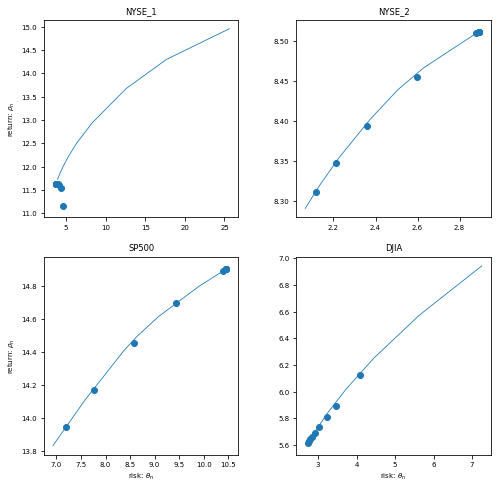

In [25]:
import matplotlib.pyplot as plt
alphas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(wspace=0.3)
p=-1
for data,ax in zip(['NYSE_1.csv','NYSE_2.csv','SP500.csv','DJIA.csv'],axes.ravel()):
    p+=1
    stocks=pd.read_csv(data)
    N=stocks.shape[0]
    d=stocks.shape[1]
    r=np.zeros((N,d))
    r=stocks.to_numpy() 
    
    ret=np.zeros(len(alphas))
    risk=np.zeros(len(alphas))
    ret_rel=np.zeros(len(alphas))
    risk_rel=np.zeros(len(alphas))
      
    mu=np.mean(r-1,axis=0)
    Sigma=(r.T-1)@(r-1)/N  
    m=10**6 
    np.random.seed(42)
    r_BS=np.exp(np.random.multivariate_normal(mu-np.diagonal(Sigma)/2,Sigma,m))
    mu_BS_est=np.mean(r_BS-1,axis=0)    
    Sigma_BS_est=(r_BS.T-1)@(r_BS-1)/m     
    
    r_BS_rel=r_BS/np.max(r_BS,axis=1).reshape(-1,1)
    mu_BS_rel=np.mean(r_BS_rel-1,axis=0)
    Sigma_BS_rel=(r_BS_rel.T-1)@(r_BS_rel-1)/m 
    
    frac=np.zeros(d)
    frac_rel=np.zeros(d)

    s=-1
    for alpha in alphas:
        s+=1
        
      #  frac=opt_fractions(alpha,r_BS)
      #  frac_rel=opt_fractions(alpha,r_BS_rel)  
        
        frac=opt_fractions_quadr(alpha,mu_BS_est,Sigma_BS_est)
        frac_rel=opt_fractions_quadr(alpha,mu_BS_rel,Sigma_BS_rel)  
        
      #  risk[s]=np.std((r_BS-1)@frac)**2
      #  ret[s]=mu_BS_est@frac
      #  risk_rel[s]=np.std((r_BS-1)@frac_rel)**2
      #  ret_rel[s]=mu_BS_est@frac_rel 
   
        risk[s]=np.dot(Sigma_BS_est@frac,frac)    
        ret[s]=mu_BS_est@frac
        risk_rel[s]=np.dot(Sigma_BS_est@frac_rel,frac_rel)  
        ret_rel[s]=mu_BS_est@frac_rel 
        
        if s==0: print(data.replace('.csv',''))
        print('alpha:',alpha)           
        print('excess risk:',10**5*risk_rel[s]-10**5*risk[s],10**5*ret_rel[s]-10**5*ret[s]) 
        print('ordinary utility risk and return:',10**5*risk[s],10**5*ret[s])
        print('relative utility risk and return:',10**5*risk_rel[s],10**5*ret_rel[s])   
      #  print(refine(frac_rel))
      #  print(refine(frac))
    ax.plot(10**4*risk,10**4*ret,linewidth=0.8)
    ax.scatter(10**4*risk_rel,10**4*ret_rel)
    ax.set_title(data.replace('.csv',''))
    if p==2 or p==3: ax.set_xlabel('risk: '+r'$\theta_n$')
    if p==0 or p==2: ax.set_ylabel('return: '+r'$\rho_n$')

The cell computes log-optimal portfolios, using the quadratic approximation, for 200 realizations of the geometric Brownian motion with parameters, estimated for NYSE$_2$ dataset. Each realization contained $252\cdot 10^k$ returns, $k=1,2,3$. 

Output: optimal portfolio weights, averaged over all realizations (Fig.3).

NYSE_2
artificial history length=2520
BCRP esimation:
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], array([0.02870009, 0.01656078, 0.03507722, 0.05742983, 0.04073886,
       0.00168401, 0.03094938, 0.02836421, 0.00337567, 0.15313394,
       0.01539281, 0.04584034, 0.07278035, 0.064025  , 0.06128784,
       0.02479893, 0.19695763, 0.02045254, 0.10245057]))
artificial history length=25200
BCRP esimation:
 ([0, 2, 3, 4, 7, 9, 11, 12, 13, 14, 16, 17, 18], array([0.01036706, 0.01550775, 0.01449696, 0.00551575, 0.004284  ,
       0.16449573, 0.00612048, 0.06724897, 0.01266682, 0.02887549,
       0.56722236, 0.00367801, 0.09952064]))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


artificial history length=252000
BCRP esimation:
 ([9, 12, 16, 18], array([0.16161435, 0.03133334, 0.72861543, 0.07843688]))


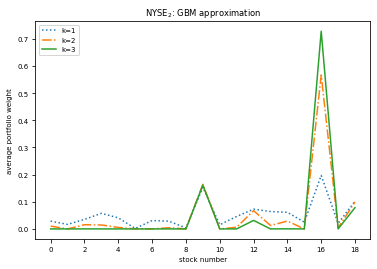

In [37]:
#ig, axes = plt.subplots(1,1,figsize=(6,3))
fig, ax = plt.subplots(figsize=(6,4))
realization_length=[252*10,252*100,252*1000]
plt.rcParams['font.size'] = 7
datasets=['NYSE_2.csv']
linestyles=[':','-.','-']
for data in datasets:
    s=-1
    stocks=pd.read_csv(data)
    N=stocks.shape[0]
    d=stocks.shape[1]
    r=np.zeros((N,d))
    r=stocks.to_numpy()   
    
    mu=np.mean(r-1,axis=0)    
    Sigma=(r.T-1)@(r-1)/N   
  
    n_realizations=200
    print(data.replace('.csv',''))
    for m in realization_length:
        s+=1
        frac=np.zeros((n_realizations,d))   
        frac_average=np.zeros(d)
        n_realizations=200       
        np.random.seed(49)
        for realization in range(n_realizations):
            r_BS=np.exp(np.random.multivariate_normal(mu-np.diagonal(Sigma)/2,Sigma,m))
            mu_BS_est=np.mean(r_BS-1,axis=0)    
            Sigma_BS_est=(r_BS.T-1)@(r_BS-1)/m            
            frac[realization]=opt_fractions_quadr(0,mu_BS_est,Sigma_BS_est)
        frac_average=np.mean(frac,axis=0)  
        print(f'artificial history length={m}')
        print('BCRP esimation:\n',refine(frac_average))
        plt.plot(frac_average,label=f"k={s+1}",linestyle=linestyles[s])
        plt.legend(loc='upper left')
        ax.xaxis.set_major_locator(plt.MultipleLocator(2))
        ax.set_title('NYSE$_2$: GBM approximation')
        ax.set_xlabel('stock number', fontsize=7)
        ax.set_ylabel('average portfolio weight', fontsize=7)  
plt.savefig('averaged_GBM.eps',dpi=400,bbox_inches='tight')